[Deep Learning Summer School 2019](http://2019.dl-lab.eu) in Gdansk, Poland  
Ordinal Regression Tutorial by [Sebastian Raschka](https://sebastianraschka.com)  
GitHub Repository: https://github.com/rasbt/DL-Gdansk2019-tutorial  

In [51]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.8
IPython 7.2.0

torch 1.1.0


# Using PyTorch Dataset Loading Utilities for Custom Dataset -- UTKFace

This notebook provides an example for how to prepare a custom dataset for PyTorch's data loading utilities. More in-depth information can be found in the official documentation at:

- [Data Loading and Processing Tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [torch.utils.data](http://pytorch.org/docs/master/data.html) API documentation

In this example, we are using the UTKFace datset, which is a face image dataset with age labels [1]:

- https://susanqq.github.io/UTKFace/

In particu

[1] Zhang, Z., Song, Y., & Qi, H. (2017). Age progression/regression by conditional adversarial autoencoder. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 5810-5818).

## Imports

In [52]:
import time
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading the Dataset

Download link from https://susanqq.github.io/UTKFace/:

- https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?usp=sharing

In [54]:
# "Unzip"
!tar -zxf UTKFace.tar.gz

In [55]:
# Get image paths
root_dir = 'UTKFace'

files = [i for i in os.listdir(root_dir) if i.endswith('.jpg')]

In [56]:
print(f'Number of images in total: {len(files)}')

Number of images in total: 23708


## Creating Label Files (CSVs)

In [57]:
labels = []

for f in files:
    age = int(f.split('_')[0])
    labels.append(age)

In [58]:
df = pd.DataFrame(files, columns=['filename'])
df['age'] = pd.Series(labels)
df.head()

,filename,age
0,26_0_3_20170119181013021.jpg.chip.jpg,26
1,1_1_0_20170109194452834.jpg.chip.jpg,1
2,26_0_1_20170113182742605.jpg.chip.jpg,26
3,26_1_1_20170113182739526.jpg.chip.jpg,26
4,54_0_1_20170120223426436.jpg.chip.jpg,54


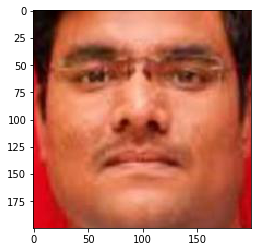

In [59]:
im = Image.open(os.path.join(root_dir, files[0]))
plt.imshow(im)
plt.show()

## Select subset

In [60]:
df = df[ (df['age'] >= 21) & (df['age'] <= 60) ]
print(f'Number of images in total: {df.shape[0]}')

Number of images in total: 16434


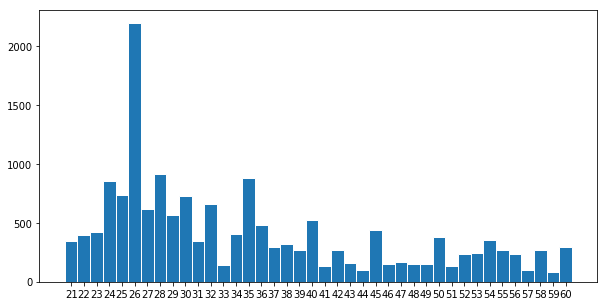

In [61]:
plt.figure(figsize=(10, 5))
plt.hist(df['age'],
         bins=range(21, 62), 
         edgecolor='white', 
         align='left')
plt.xticks(np.unique(df['age'].values))
plt.show()

Normalize labels such that they start with `0`:

In [62]:
df['age'] = df['age'].values - int(df['age'].min())

Seperate dataset into training and test subsets:

In [63]:
np.random.seed(123)
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

Save data partitioning as CSV:

In [64]:
df_train.to_csv('training_set.csv', index=False)

In [65]:
df_test.to_csv('test_set.csv', index=False)

In [66]:
num_ages = np.unique(df['age'].values).shape[0]
print(f'Number of age labels: {num_ages}')

Number of age labels: 40


In [67]:
print(f'Number of training examples: {df_train.shape[0]}')
print(f'Number of test examples: {df_test.shape[0]}')

Number of training examples: 13176
Number of test examples: 3258


## Implementing a Custom Dataset Class

In [68]:
class UTKDatasetAge(Dataset):
    """Custom Dataset for loading UTKFace images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.df = df
        self.y = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.df.iloc[index]['filename']))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

## Setting Up DataLoaders

In [71]:
TRAIN_CSV_PATH = 'training_set.csv'
TEST_CSV_PATH = 'test_set.csv'
IMAGE_PATH = 'UTKFace'
BATCH_SIZE = 128

In [75]:
train_indices = torch.arange(0, df_train.shape[0]-1000).numpy()
valid_indices = torch.arange(df_train.shape[0]-1000, df_train.shape[0]).numpy()

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.RandomCrop((120, 120)),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.CenterCrop((120, 120)),
                                     transforms.ToTensor()])


train_dataset = UTKDatasetAge(csv_path=TRAIN_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=train_transform)

valid_dataset = UTKDatasetAge(csv_path=TRAIN_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=test_transform)

test_dataset = UTKDatasetAge(csv_path=TEST_CSV_PATH,
                             img_dir=IMAGE_PATH,
                             transform=test_transform)




train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

In [76]:
# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 120, 120])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 120, 120])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 120, 120])
Image label dimensions: torch.Size([128])


## Iterating through the Custom Dataset

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## Expected Error for Average Classifier

$$\lfloor \; \mathrm{E}[X] \; \rceil= \bigg \lfloor \sum_{i=1}^{k} x_{i} p_{i}=x_{1} p_{1}+x_{2} p_{2}+\cdots+x_{k} p_{k} \bigg \rceil$$

In [80]:
for i in np.unique(df_train['age'].values):
    err = np.sum(np.abs(df_train['age'] - i))
    print(f'Error class {i}: {err/df_train.shape[0]}')

Error class 0: 13.907710989678202
Error class 1: 12.949301760777171
Error class 2: 12.039162112932605
Error class 3: 11.180327868852459
Error class 4: 10.428658166363084
Error class 5: 9.766545233758348
Error class 6: 9.375227686703097
Error class 7: 9.058287795992713
Error class 8: 8.853369763205828
Error class 9: 8.717213114754099
Error class 10: 8.668943533697632
Error class 11: 8.661809350333941
Error class 12: 8.736642380085003
Error class 13: 8.82953855494839
Error class 14: 8.973891924711596
Error class 15: 9.219945355191257
Error class 16: 9.526411657559198
Error class 17: 9.869156041287189
Error class 18: 10.25333940497875
Error class 19: 10.669398907103826
Error class 20: 11.147844565877353
Error class 21: 11.643746205221616
Error class 22: 12.171068609593199
Error class 23: 12.716605950212507
Error class 24: 13.27489374620522
Error class 25: 13.887219186399514
Error class 26: 14.519884638737098
Error class 27: 15.172131147540984
Error class 28: 15.843655130540377
Error class

In [78]:
for i in np.unique(df_test['age'].values):
    err = np.sum(np.abs(df_test['age'] - i))
    print(f'Error class {i}: {err/df_test.shape[0]}')

Error class 0: 14.21792510742787
Error class 1: 13.262124002455494
Error class 2: 12.353591160220995
Error class 3: 11.499079189686924
Error class 4: 10.738489871086555
Error class 5: 10.066298342541437
Error class 6: 9.647636586863106
Error class 7: 9.305709023941068
Error class 8: 9.07427869858809
Error class 9: 8.914671577655003
Error class 10: 8.844076120319214
Error class 11: 8.821976672805402
Error class 12: 8.875997544505832
Error class 13: 8.94475138121547
Error class 14: 9.056476365868631
Error class 15: 9.297114794352364
Error class 16: 9.589932473910375
Error class 17: 9.915899324739105
Error class 18: 10.273787599754451
Error class 19: 10.666052793124617
Error class 20: 11.128913443830571
Error class 21: 11.602209944751381
Error class 22: 12.111724984653161
Error class 23: 12.643953345610804
Error class 24: 13.186003683241251
Error class 25: 13.779619398403929
Error class 26: 14.384898710865562
Error class 27: 15.015346838551258
Error class 28: 15.661755678330264
Error clas

## Expected CrossEntropy loss for random classifier

In [83]:
-np.log(1/40)

3.6888794541139363